# Conformalized predictive simulations for univariate time series

<span>
<a target="_blank" href="https://colab.research.google.com/github/Techtonique/ahead_python/blob/main/ahead/demo/thierrymoudiki_20240408_conformal_bench.ipynb">
  <img style="width: inherit;" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
</span>


# 1 - M3 competition (R code), 3003 time series

## 1 - 0 - Import packages

In [ ]:
!pip install rpy2

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R

utils::install.packages(c('foreach', 'forecast', 'fpp', 'fpp2', 'remotes', 'Mcomp'),
                        repos="https://cran.r-project.org")
remotes::install_github("Techtonique/ahead")
remotes::install_github("thierrymoudiki/simulatetimeseries")



suppressWarnings(library(datasets))
suppressWarnings(library(forecast))
suppressWarnings(library(fpp2))
suppressWarnings(library(ahead))
suppressWarnings(library(Mcomp))

In [ ]:
%%R

remotes::install_github("herbps10/AdaptiveConformal", force=TRUE)

suppressWarnings(library(AdaptiveConformal))

In [ ]:
%%R

remotes::install_github("thierrymoudiki/misc")

suppressWarnings(library(misc))

In [7]:
%%R

print(length(M3))
print(length(M3[[1000]]$x))
print(length(M3[[1000]]$xx))
print(length(M3[[100]]$x))
print(length(M3[[100]]$xx))

[1] 3003
[1] 44
[1] 8
[1] 14
[1] 6


## 1 - 1 - Functions and data set

In [8]:
%%R

winkler_score <- function(obj, actual, level = 95) {
  alpha <- 1 - level / 100
  lt <- obj$lower
  ut <- obj$upper
  n_points <- length(actual)
  stopifnot((n_points == length(lt)) && (n_points == length(ut)))
  diff_lt <- lt - actual
  diff_bounds <- ut - lt
  diff_ut <- actual - ut
  score <-
    diff_bounds + (2 / alpha) * (pmax(diff_lt, 0) + pmax(diff_ut, 0))
  return(mean(score))
}

# moving block bootstrap
mbb2 <- function(r,
                 n,
                 b,
                 seed = 123,
                 return_indices = FALSE)
{
  n_obs <- dim(r)[1]
  n_series <- dim(r)[2]
  b <- floor(min(max(3L, b), n_obs - 1L))
  if(n >= n_obs)
    stop("forecasting horizon must be < number of observations")
  n <- min(n_obs, n)

  set.seed(seed) # important for base::sample below

  r_bt <- matrix(NA, nrow = n_obs, ncol = dim(r)[2])  # local vector for a bootstrap replication

  #cat("n_obs", n_obs, "\n")
  #cat("b", b, "\n")
  for (i in 1:ceiling(n_obs/b)) {
    #cat("i: ", i, "----- \n")
    endpoint <- sample(b:n_obs, size = 1)
    #cat("endpoint", endpoint, "\n")
    try(r_bt[(i - 1)*b + 1:b, ] <- r[endpoint - (b:1) + 1, ],
        silent = TRUE)
  }

  tmp <- matrix(r_bt[(1:n), ], nrow = n, ncol = n_series)

  if(return_indices == FALSE)
  {
    return(tmp)
  } else {
    return(arrayInd(match(tmp, r), .dim = dim(r))[1:n, 1])
  }
}
mbb2 <- memoise::memoise(mbb2)

# split data set
split_dataset <- function(x,
                          split_prob = 0.8,
                          transformation=c("none",
                                           "boxcox",
                                           "diff",
                                           "diffboxcox"))
{
  transformation <- match.arg(transformation)

  if (identical(transformation, "boxcox"))
  {
    x <- forecast::BoxCox(x, lambda = "auto")
  }
  if (identical(transformation, "diff"))
  {
    x <- diff(x)
  }
  if (identical(transformation, "diffboxcox"))
  {
    x <- diff(forecast::BoxCox(x, lambda = "auto"))
  }

  freq_x <- frequency(x)
  n <- floor(split_prob*length(x))
  half_n <- floor(n/2)
  x_train <- ts(x[1:half_n],
                start=start(x),
                frequency = freq_x)
  x_calib <- ts(x[(half_n + 1):n],
                start=tsp(x_train)[2] + 1 / freq_x,
                frequency = freq_x)
  x_test <- ts(x[(n + 1):length(x)],
               start=tsp(x_calib)[2] + 1 / freq_x,
               frequency = freq_x)
  res <- vector("list", 4)
  res$x <- x
  res$x_train <- x_train
  res$x_calib <- x_calib
  res$x_test <- x_test
  return(res)
}
split_dataset <- memoise::memoise(split_dataset)

# forecasting function
forecast_function <- function(x,
                              method = c("theta",
                                         "dynrm",
                                         "snaive"),
                              split_prob = 0.8,
                              block_size = 5,
                              B = 250,
                              level = 95,
                              seed=123)
{
  obj_ts <- split_dataset(x, split_prob=split_prob)
  method <- match.arg(method)
  freq_x <- frequency(obj_ts$x)
  fcast_func <- switch(method,
                       dynrm = ahead::dynrmf,
                       theta = forecast::thetaf,
                       snaive = forecast::snaive)

  # calibration
  obj <- fcast_func(obj_ts$x_train,
                    h=length(obj_ts$x_calib)) # train on training set predict on calibration set
  calibrated_resids <- obj_ts$x_calib - obj$mean # obtain calibrated residuals
  obj_fcast <- fcast_func(obj_ts$x_calib,
                          h=length(obj_ts$x_test)) # train on calibration set

  sims <- ts(sapply(1:B, function(i) mbb2(matrix(calibrated_resids,
                                                 ncol = 1),
                                          n=length(obj_ts$x_test),
                                          b=block_size,
                                          seed=i+seed*100)),
             start = start(obj_ts$x_test),
             frequency = frequency(obj_ts$x_test))

  preds <- obj_fcast$mean + sims
  obj_fcast2 <- list()
  obj_fcast2$level <- level
  obj_fcast2$x <- obj_ts$x_calib
  start_preds <- start(obj_fcast$mean)
  obj_fcast2$mean <- ts(rowMeans(preds),
                        start = start_preds,
                        frequency = freq_x)
  obj_fcast2$upper <- ts(apply(preds, 1, function(x)
    stats::quantile(x, probs = 1 - (1 - level / 100) / 2)),
    start = start_preds,
    frequency = freq_x)
  obj_fcast2$lower <- ts(apply(preds, 1, function(x)
    stats::quantile(x, probs = (1 - level / 100) / 2)),
    start = start_preds,
    frequency = freq_x)
  obj_fcast2$method <- method

  class(obj_fcast2) <- "forecast"

  return(obj_fcast2)
}


compute_errors <- function(obj, preds)
{
    res <- vector("list", 8)
    true <- obj$mean
    names(res) <- c("coverage", "winkler",
                    "ME", "RMSE", "MAE",
                    "MPE", "MAPE", "MASE")
    res$coverage <- mean(true > obj$lower & true < obj$upper)*100
    res$winkler <- winkler_score(obj, actual=true)
    res$ME <- mean(true - preds)
    res$RMSE <- sqrt(mean((true - preds)^2))
    res$MAE <- mean(abs(true - preds))
    res$MPE <- mean((true - preds)/true)
    res$MAPE <- mean(abs(true - preds)/true)
    res$MASE <- mean(abs(true - preds))/mean(abs(true - mean(true)))
    return(res)
}


In [9]:
%%R

all_datasets <- lapply(M3, function(s) ts(c(s$x, s$xx),
                                          start=start(s$x),
                                          frequency=frequency(s$x)))
names(all_datasets) <- names(M3)

In [ ]:
%%R

library("AdaptiveConformal")
library("ahead")
library("simulatetimeseries")
library("foreach")
library("forecast")

In [11]:
%%R

conformal_methods <- c("splitconformal", "AgACI", "SAOCP", "SF-OGD")
metrics <- c("coverage", "winkler",
            "ME", "RMSE", "MAE",
            "MPE", "MAPE", "MASE")
# will contain results for each time series
params_grid <- expand.grid(conformal_methods, metrics)
colnames(params_grid) <- c("conformal_method", "metric")
params_grid <- misc::sort_df(params_grid, by="conformal_method", decreasing = FALSE)
params_grid <- cbind(params_grid, value=NA)

rownames(params_grid) <- NULL
print(params_grid)

   conformal_method   metric value
1    splitconformal coverage    NA
2    splitconformal  winkler    NA
3    splitconformal       ME    NA
4    splitconformal     RMSE    NA
5    splitconformal      MAE    NA
6    splitconformal      MPE    NA
7    splitconformal     MAPE    NA
8    splitconformal     MASE    NA
9             AgACI coverage    NA
10            AgACI  winkler    NA
11            AgACI       ME    NA
12            AgACI     RMSE    NA
13            AgACI      MAE    NA
14            AgACI      MPE    NA
15            AgACI     MAPE    NA
16            AgACI     MASE    NA
17            SAOCP coverage    NA
18            SAOCP  winkler    NA
19            SAOCP       ME    NA
20            SAOCP     RMSE    NA
21            SAOCP      MAE    NA
22            SAOCP      MPE    NA
23            SAOCP     MAPE    NA
24            SAOCP     MASE    NA
25           SF-OGD coverage    NA
26           SF-OGD  winkler    NA
27           SF-OGD       ME    NA
28           SF-OGD 

           SF-OGD     MASE    NA


In [12]:
%%R

results <- vector("list", length(all_datasets))
names(results) <- names(all_datasets)

for (i in 1:length(all_datasets))
{
 results[[i]] <- params_grid
}

In [13]:
%%R

print(results[[1]])

   conformal_method   metric

 value
1    splitconformal coverage    NA
2    splitconformal  winkler    NA
3    splitconformal       ME    NA
4    splitconformal     RMSE    NA
5    splitconformal      MAE    NA
6    splitconformal      MPE    NA
7    splitconformal     MAPE    NA
8    splitconformal     MASE    NA
9             AgACI coverage    NA
10            AgACI  winkler    NA
11            AgACI       ME    NA
12            AgACI     RMSE    NA
13            AgACI      MAE    NA
14            AgACI      MPE    NA
15            AgACI     MAPE    NA
16            AgACI     MASE    NA
17            SAOCP coverage    NA
18            SAOCP  winkler    NA
19            SAOCP       ME    NA
20            SAOCP     RMSE    NA
21            SAOCP      MAE    NA
22            SAOCP      MPE    NA
23            SAOCP     MAPE    NA
24            SAOCP     MASE    NA
25           SF-OGD coverage    NA
26           SF-OGD  winkler    NA
27           SF-OGD       ME    NA
28           SF-OGD     RMSE    NA
29           

## 1 - 2 - main loops

In [14]:
%%R

all_datasets[[1000]]

       Qtr1   Qtr2   Qtr3   Qtr4
1980 4381.5 4107.5 3959.0 4117.5
1981 4182.5 4559.5 4652.0 4487.0
1982 4475.5 4472.0 4215.0 4282.0
1983 4424.5 4395.5 4466.5 4565.5
1984 4841.0 4645.0 4904.5 4980.5
1985 4953.5 4951.5 5021.5 5073.5
1986 5119.0 5120.5 5181.5 5071.0
1987 5188.5 5162.5 5511.0 5594.5
1988 5239.5 5800.5 5694.0 5884.0
1989 5841.0 6226.0 6268.5 6262.5
1990 6290.0 6621.5 6662.5 6745.5
1991 6722.0 6509.5 6523.0 6633.5
1992 7003.5 6702.0 7023.5 6970.0


In [15]:
%%R

(nb_iter_datasets <- length(all_datasets))


pb <- txtProgressBar(min = 0,
                     max = nb_iter_datasets, #nb_iter_datasets,
                     style = 3)

start_time <- proc.time()[3]
for (i in 1:nb_iter_datasets) # loop levels and methods
{
    y <- all_datasets[[i]]
    splitted_ts <- simulatetimeseries::splitts(y = y,
                                               split_prob = 0.8)
    y_train <- splitted_ts$training
    y_test <- splitted_ts$testing
    idx_row <- 1 # start filling results[[i]] at row
    for (j in 1:nrow(results[[i]]))
    {
        seed_i_j<- 100*i+300*j
        set.seed(seed_i_j)
        conformal_method <- as.character(results[[i]]$conformal_method[j])

        if (conformal_method == "splitconformal")
        {
            obj <- forecast_function(y)

            result_accuracy <- compute_errors(obj, y_test)

            results[[i]][idx_row, 3] <- result_accuracy$coverage
            results[[i]][idx_row + 1, 3] <- result_accuracy$winkler
            results[[i]][idx_row + 2, 3] <- result_accuracy$ME
            results[[i]][idx_row + 3, 3] <- result_accuracy$RMSE
            results[[i]][idx_row + 4, 3] <- result_accuracy$MAE
            results[[i]][idx_row + 5, 3] <- result_accuracy$MPE
            results[[i]][idx_row + 6, 3] <- result_accuracy$MAPE
            results[[i]][idx_row + 7, 3] <- result_accuracy$MASE
        }

        if (conformal_method %in% c("AgACI", "SAOCP", "SF-OGD"))
        {
          idx_method <- switch(conformal_method,
                               "AgACI" = 0,
                               "SAOCP" = 8,
                               "SF-OGD" = 16)

          obj <- forecast::thetaf(y_train, h=length(y_test)
          , level = 95L) # the function AdaptiveConformal::aci seems to be broken: for obs1, lower=mean=upper

          result_accuracy <- compute_errors(obj, y_test)

          preds <- obj$mean

          start_time <- proc.time()[3]
          result_ac <- AdaptiveConformal::aci(as.vector(y_test),
                                          as.vector(preds),
                                          method = conformal_method,
                                          alpha = 0.95)
          elapsed <- proc.time()[3] - start_time

          result_ac$lower <- result_ac$intervals[, 1]
          result_ac$upper <- result_ac$intervals[, 2]

          results[[i]][idx_row + 8 + idx_method, 3] <- mean((y_test >= result_ac$lower)*(y_test <= result_ac$upper))*100
          results[[i]][idx_row + 9 + idx_method, 3] <- winkler_score(result_ac,
                                              actual=y_test,
                                              level = 95L)
          results[[i]][idx_row + 10 + idx_method, 3] <- result_accuracy$ME
          results[[i]][idx_row + 11 + idx_method, 3] <- result_accuracy$RMSE
          results[[i]][idx_row + 12 + idx_method, 3] <- result_accuracy$MAE
          results[[i]][idx_row + 13 + idx_method, 3] <- result_accuracy$MPE
          results[[i]][idx_row + 14 + idx_method, 3] <- result_accuracy$MAPE
          results[[i]][idx_row + 15 + idx_method, 3] <- result_accuracy$MASE
        }
        }

  utils::setTxtProgressBar(pb, i)
}
print(proc.time()[3] - start_time)
close(pb)




  |======================================================================| 100%elapsed 
  0.026 



In [16]:
%%R

saveRDS(results, "results_M3_coverages_accuracy_20241031.rds")

In [17]:
%%R

results[[900]]

   conformal_method   metric         value
1    splitconformal coverage  100.00000000
2    splitconformal  winkler  981.84974777
3    splitconformal       ME  559.58561941
4    splitconformal     RMSE  593.74425710
5    splitconformal      MAE  559.58561941
6    splitconformal      MPE    0.09915813
7    splitconformal     MAPE    0.09915813
8    splitconformal     MASE   11.57573873
9             AgACI coverage   86.66666667
10            AgACI  winkler 1770.04184551
11            AgACI       ME -115.63456132
12            AgACI     RMSE  234.42706737
13            AgACI      MAE  206.06445835
14            AgACI      MPE   -0.02318314
15            AgACI     MAPE    0.04146758
16            AgACI     MASE    8.86251472
17            SAOCP coverage    0.00000000
18            SAOCP  winkler 8126.43890773
19            SAOCP       ME -115.63456132
20            SAOCP     RMSE  234.42706737
21            SAOCP      MAE  206.06445835
22            SAOCP      MPE   -0.02318314
23         

In [18]:
%%R

names(results)[2005]

[1] "N2005"


In [ ]:
%%R

utils::install.packages(c("dplyr", "forecast"), repos = "https://cran.r-project.org")

library(dplyr)
library(forecast)

In [ ]:
%%R

# Use foreach to iterate and combine data frames with an identifying column
combined_results <- foreach::foreach(name = names(results), .combine = dplyr::bind_rows) %dopar% {
    type <- M3[[name]]$type
    period <- M3[[name]]$period
  results[[name]] %>%
    mutate(series_name = name,
           type = type,
           period = period)
}

In [21]:
%%R

print(head(combined_results))
print(tail(combined_results))

  conformal_method   metric         value series_name  type period
1   splitconformal coverage  100.00000000       N0001 MICRO YEARLY
2   splitconformal  winkler  961.37125000       N0001 MICRO YEARLY
3   splitconformal       ME -451.78614069       N0001 MICRO YEARLY
4   splitconformal     RMSE  503.17233162       N0001 MICRO YEARLY
5   splitconformal      MAE  451.78614069       N0001 MICRO YEARLY
6   splitconformal      MPE   -0.05761112       N0001 MICRO YEARLY
      conformal_method metric       value series_name  type period
96091           SF-OGD     ME 292.1919670       N3003 OTHER  OTHER
96092           SF-OGD   RMSE 331.0231842       N3003 OTHER  OTHER
96093           SF-OGD    MAE 292.1919670       N3003 OTHER  OTHER
96094           SF-OGD    MPE   0.0753467       N3003 OTHER  OTHER
96095           SF-OGD   MAPE   0.0753467       N3003 OTHER  OTHER
96096           SF-OGD   MASE   5.1971807       N3003 OTHER  OTHER


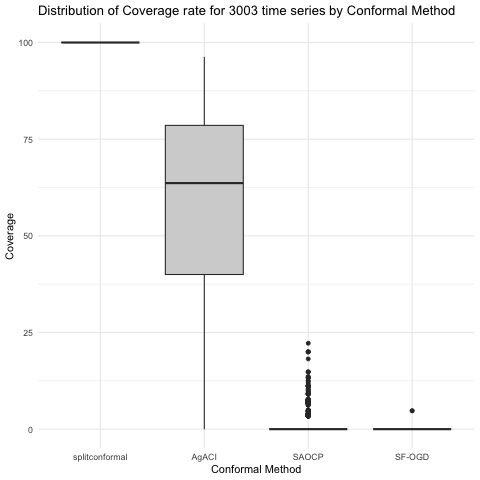

In [22]:
%%R

library(ggplot2)

# Filter the data to only include rows where metric is 'coverage'
df_coverage <- combined_results %>% filter(metric == 'coverage')

# Boxplot
ggplot(df_coverage, aes(x = conformal_method, y = value)) +
  geom_boxplot(fill = "lightgray") +
  labs(title = "Distribution of Coverage rate for 3003 time series by Conformal Method",
       x = "Conformal Method",
       y = "Coverage") +
  theme_minimal()


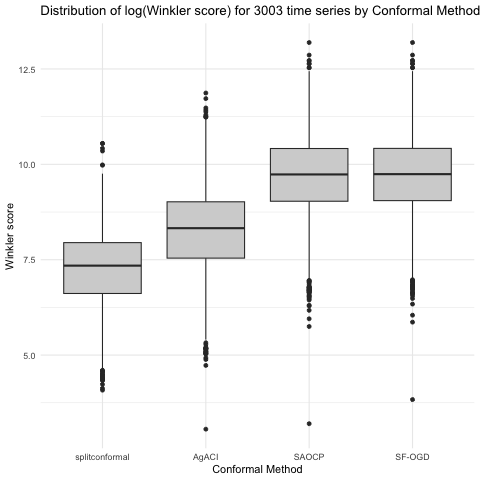

In [23]:
%%R

# Winkler score, the lower the better
df_winkler <- combined_results %>% filter(metric == 'winkler')

# Boxplot
ggplot(df_winkler, aes(x = conformal_method, y = log(value))) +
  geom_boxplot(fill = "lightgray") +
  labs(title = "Distribution of log(Winkler score) for 3003 time series by Conformal Method",
       x = "Conformal Method",
       y = "Winkler score") +
  theme_minimal()


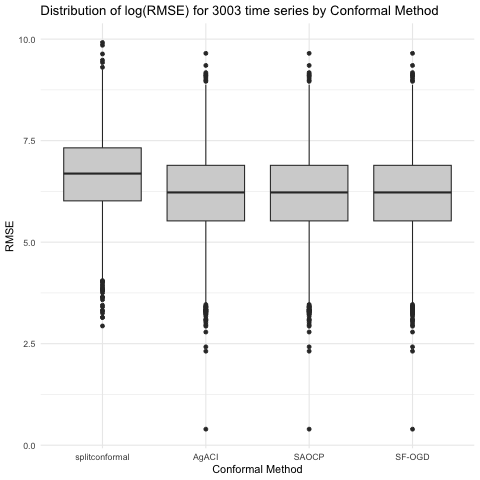

In [24]:
%%R

# Filter the data to only include rows where metric is 'coverage'
df_RMSE <- combined_results %>% filter(metric == 'RMSE')

# Boxplot
ggplot(df_RMSE, aes(x = conformal_method, y = log(value))) +
  geom_boxplot(fill = "lightgray") +
  labs(title = "Distribution of log(RMSE) for 3003 time series by Conformal Method",
       x = "Conformal Method",
       y = "RMSE") +
  theme_minimal()


The point is really uncertainty in this context, i.e coverage rate and Winkler score. Not RMSE. 

In [25]:
%%R

saveRDS(combined_results, "combined_results_M3_coverages_accuracy_20241031.rds")

In [26]:
%%R

# Assuming 'combined_results' is the data frame you loaded from the RDS file
average_coverage <- combined_results %>%
  group_by(conformal_method, period) %>%
  summarise(average_coverage = mean(value[metric == "coverage"]))

average_coverage

`summarise()` has grouped output by 'conformal_method'. You can override using
the `.groups` argument.
# A tibble: 16 × 3
# Groups:   conformal_method [4]
   conformal_method period    average_coverage
   <fct>            <chr>                <dbl>
 1 splitconformal   MONTHLY           100     
 2 splitconformal   OTHER             100     
 3 splitconformal   QUARTERLY         100     
 4 splitconformal   YEARLY            100     
 5 AgACI            MONTHLY            72.4   
 6 AgACI            OTHER              48.4   
 7 AgACI            QUARTERLY          52.2   
 8 AgACI            YEARLY             31.8   
 9 SAOCP            MONTHLY             0.880 
10 SAOCP            OTHER               1.26  
11 SAOCP            QUARTERLY           0.275 
12 SAOCP            YEARLY              0.109 
13 SF-OGD           MONTHLY             0     
14 SF-OGD           OTHER               0.0547
15 SF-OGD           QUARTERLY           0     
16 SF-OGD           YEARLY              0     

In [27]:
%%R

# Assuming 'combined_results' is the data frame you loaded from the RDS file
# Winkler score, the lower the better
average_winkler <- combined_results %>%
  group_by(conformal_method, period) %>%
  summarise(average_winkler = mean(value[metric == "winkler"]))

average_winkler

`summarise()` has grouped output by 'conformal_method'. You can override using
the `.groups` argument.
# A tibble: 16 × 3
# Groups:   conformal_method [4]
   conformal_method period    average_winkler
   <fct>            <chr>               <dbl>
 1 splitconformal   MONTHLY             2748.
 2 splitconformal   OTHER               1174.
 3 splitconformal   QUARTERLY           1663.
 4 splitconformal   YEARLY              1735.
 5 AgACI            MONTHLY             5369.
 6 AgACI            OTHER               2238.
 7 AgACI            QUARTERLY           5848.
 8 AgACI            YEARLY             14569.
 9 SAOCP            MONTHLY            25397.
10 SAOCP            OTHER              12282.
11 SAOCP            QUARTERLY          21957.
12 SAOCP            YEARLY             41459.
13 SF-OGD           MONTHLY            25570.
14 SF-OGD           OTHER              12401.
15 SF-OGD           QUARTERLY          22036.
16 SF-OGD           YEARLY             41505.


In [28]:
%%R

# Assuming 'combined_results' is the data frame you loaded from the RDS file
average_RMSE <- combined_results %>%
  group_by(conformal_method, period) %>%
  summarise(average_RMSE = mean(value[metric == "RMSE"]))

average_RMSE

`summarise()` has grouped output by 'conformal_method'. You can override using
the `.groups` argument.
# A tibble: 16 × 3
# Groups:   conformal_method [4]
   conformal_method period    average_RMSE
   <fct>            <chr>            <dbl>
 1 splitconformal   MONTHLY          1194.
 2 splitconformal   OTHER             668.
 3 splitconformal   QUARTERLY        1129.
 4 splitconformal   YEARLY           1662.
 5 AgACI            MONTHLY           780.
 6 AgACI            OTHER             360.
 7 AgACI            QUARTERLY         649.
 8 AgACI            YEARLY           1183.
 9 SAOCP            MONTHLY           780.
10 SAOCP            OTHER             360.
11 SAOCP            QUARTERLY         649.
12 SAOCP            YEARLY           1183.
13 SF-OGD           MONTHLY           780.
14 SF-OGD           OTHER             360.
15 SF-OGD           QUARTERLY         649.
16 SF-OGD           YEARLY           1183.


Again, the point is really uncertainty in this context, i.e coverage rate and Winkler score. Not RMSE. 

In [ ]:
%%R

utils::install.packages("knitr")
utils::install.packages("kableExtra")

In [31]:
%%R

library(knitr)
library(kableExtra)

In [32]:
%%R

# Assuming 'average_coverage' is your data frame
kable(average_coverage, format = "latex", booktabs = TRUE,
      caption = "Average Coverage by Method and Period") %>%
  kable_styling(latex_options = c("striped", "scale_down"))

\begin{table}
\centering
\caption{Average Coverage by Method and Period}
\centering
\resizebox{\ifdim\width>\linewidth\linewidth\else\width\fi}{!}{
\begin{tabular}[t]{llr}
\toprule
conformal\_method & period & average\_coverage\\
\midrule
\cellcolor{gray!10}{splitconformal} & \cellcolor{gray!10}{MONTHLY} & \cellcolor{gray!10}{100.0000000}\\
splitconformal & OTHER & 100.0000000\\
\cellcolor{gray!10}{splitconformal} & \cellcolor{gray!10}{QUARTERLY} & \cellcolor{gray!10}{100.0000000}\\
splitconformal & YEARLY & 100.0000000\\
\cellcolor{gray!10}{AgACI} & \cellcolor{gray!10}{MONTHLY} & \cellcolor{gray!10}{72.4303909}\\
\addlinespace
AgACI & OTHER & 48.3811720\\
\cellcolor{gray!10}{AgACI} & \cellcolor{gray!10}{QUARTERLY} & \cellcolor{gray!10}{52.1629623}\\
AgACI & YEARLY & 31.8191214\\
\cellcolor{gray!10}{SAOCP} & \cellcolor{gray!10}{MONTHLY} & \cellcolor{gray!10}{0.8799117}\\
SAOCP & OTHER & 1.2609469\\
\addlinespace
\cellcolor{gray!10}{SAOCP} & \cellcolor{gray!10}{QUARTERLY} & \cellcolor{g

In [33]:
%%R

# Assuming 'average_winkler' is your data frame
kable(average_winkler, format = "latex", booktabs = TRUE,
      caption = "Average Winkler Score by Method and Period") %>%
  kable_styling(latex_options = c("striped", "scale_down"))


\begin{table}
\centering
\caption{Average Winkler Score by Method and Period}
\centering
\resizebox{\ifdim\width>\linewidth\linewidth\else\width\fi}{!}{
\begin{tabular}[t]{llr}
\toprule
conformal\_method & period & average\_winkler\\
\midrule
\cellcolor{gray!10}{splitconformal} & \cellcolor{gray!10}{MONTHLY} & \cellcolor{gray!10}{2748.174}\\
splitconformal & OTHER & 1174.329\\
\cellcolor{gray!10}{splitconformal} & \cellcolor{gray!10}{QUARTERLY} & \cellcolor{gray!10}{1663.088}\\
splitconformal & YEARLY & 1735.325\\
\cellcolor{gray!10}{AgACI} & \cellcolor{gray!10}{MONTHLY} & \cellcolor{gray!10}{5368.826}\\
\addlinespace
AgACI & OTHER & 2237.696\\
\cellcolor{gray!10}{AgACI} & \cellcolor{gray!10}{QUARTERLY} & \cellcolor{gray!10}{5847.555}\\
AgACI & YEARLY & 14568.552\\
\cellcolor{gray!10}{SAOCP} & \cellcolor{gray!10}{MONTHLY} & \cellcolor{gray!10}{25396.600}\\
SAOCP & OTHER & 12282.197\\
\addlinespace
\cellcolor{gray!10}{SAOCP} & \cellcolor{gray!10}{QUARTERLY} & \cellcolor{gray!10}{21956.8

In [34]:
%%R

# Assuming 'average_RMSE' is your data frame
kable(average_RMSE, format = "latex", booktabs = TRUE,
      caption = "Average RMSE by Method and Period") %>%
  kable_styling(latex_options = c("striped", "scale_down"))

\begin{table}
\centering
\caption{Average RMSE by Method and Period}
\centering
\resizebox{\ifdim\width>\linewidth\linewidth\else\width\fi}{!}{
\begin{tabular}[t]{llr}
\toprule
conformal\_method & period & average\_RMSE\\
\midrule
\cellcolor{gray!10}{splitconformal} & \cellcolor{gray!10}{MONTHLY} & \cellcolor{gray!10}{1193.5822}\\
splitconformal & OTHER & 667.5194\\
\cellcolor{gray!10}{splitconformal} & \cellcolor{gray!10}{QUARTERLY} & \cellcolor{gray!10}{1128.5092}\\
splitconformal & YEARLY & 1662.1212\\
\cellcolor{gray!10}{AgACI} & \cellcolor{gray!10}{MONTHLY} & \cellcolor{gray!10}{779.9480}\\
\addlinespace
AgACI & OTHER & 359.7805\\
\cellcolor{gray!10}{AgACI} & \cellcolor{gray!10}{QUARTERLY} & \cellcolor{gray!10}{649.2999}\\
AgACI & YEARLY & 1182.6598\\
\cellcolor{gray!10}{SAOCP} & \cellcolor{gray!10}{MONTHLY} & \cellcolor{gray!10}{779.9480}\\
SAOCP & OTHER & 359.7805\\
\addlinespace
\cellcolor{gray!10}{SAOCP} & \cellcolor{gray!10}{QUARTERLY} & \cellcolor{gray!10}{649.2999}\\
SAOCP 

# 2 - M5 competition (Python code), 42840 time series aggregated by item (3049 items)

## 2 - 1 - Loading packages

In [ ]:
!pip install nnetsauce xgboost lightgbm numpy pandas scikit-learn

In [36]:
import nnetsauce as ns
import lightgbm as lgb
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor

## 2 - 2 - Useful functions

In [37]:
def calculate_coverage(lower_pred, upper_pred, y_true):
    """Calculate coverage of the prediction intervals."""
    within_bounds = np.logical_and(lower_pred <= y_true, y_true <= upper_pred)
    return np.mean(within_bounds)

def calculate_winkler_score(lower_pred, upper_pred, y_true, alpha=0.05):
    """Calculate Winkler score for predictions."""

    penalty = 2*np.maximum(lower_pred - y_true, 0)/alpha

    penalty += 2*np.maximum(y_true - upper_pred, 0)/alpha

    scores = (upper_pred - lower_pred) + penalty

    return np.mean(scores)


## 2 - 3 Loading data <a class="anchor" id="data"></a>

### Sales Training Data

There are initially 42840 time series in the M5 competition. They're aggregated here by item.

In [38]:
df = pd.read_csv("https://raw.githubusercontent.com/Techtonique/datasets/refs/heads/main/time_series/univariate/m5-forecasting-uncertainty-sales-per-item.csv")
df.head()

,item_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS_1_001,6,6,4,6,7,18,10,4,11,...,4,4,30,7,5,3,6,2,16,6
1,FOODS_1_002,4,5,7,4,3,4,1,7,2,...,5,9,4,1,3,5,5,3,3,1
2,FOODS_1_003,14,8,3,6,3,8,13,10,11,...,7,3,5,6,3,4,4,3,11,5
3,FOODS_1_004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,FOODS_1_005,34,32,13,20,10,21,18,20,25,...,16,14,14,18,18,27,12,15,38,9


In [39]:
print(df.describe())

          d_1     d_2     d_3     d_4     d_5     d_6     d_7     d_8     d_9  \
count 3049.00 3049.00 3049.00 3049.00 3049.00 3049.00 3049.00 3049.00 3049.00   
mean    10.70   10.41    7.80    8.33    6.28    9.58    9.19   12.44   10.74   
std     40.83   42.11   27.32   33.27   23.33   35.77   37.81   51.89   44.53   
min      0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
25%      0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
50%      0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
75%      9.00    9.00    6.00    7.00    5.00    8.00    7.00   10.00    9.00   
max   1345.00 1534.00  757.00 1196.00  749.00 1064.00 1187.00 1745.00 1367.00   

         d_10  ...  d_1904  d_1905  d_1906  d_1907  d_1908  d_1909  d_1910  \
count 3049.00  ... 3049.00 3049.00 3049.00 3049.00 3049.00 3049.00 3049.00   
mean     8.39  ...   13.71   15.86   16.94   12.48   12.32   11.59   11.49   
std     28.00  ...   27.06   31.44  

In [40]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3049 entries, 0 to 3048
Columns: 1914 entries, item_id to d_1913
dtypes: int64(1913), object(1)
memory usage: 44.5+ MB
None


## 2 - 4 Forecasting

In [41]:
from time import time

### 2 - 4 - 1 Functions

In [42]:
def forecast(df, idx=0, model="xgb", pi_method= "quantile",
             pct_train=0.9, **kwargs):

  assert pct_train > 0.6, "must have pct_train > 0.6"

  x = df.iloc[idx, 1:].diff().dropna().values.astype(np.float64)
  n_points = len(x)
  x_train = x[:int(n_points*pct_train)].ravel()
  x_test = x[int(n_points*pct_train):].ravel()
  lags = 1 # number of lags to consider
  h = len(x_test)

  if pi_method == "conformal":

    if model == "xgb":
      regr = ns.MTS(obj=xgb.XGBRegressor(
                  tree_method="hist", **kwargs),
                  n_hidden_features=0,
                  type_pi="scp2-kde", # split conformal prediction with KDE simulation
                  replications=250, # number of simulations
                  lags=lags,
                  show_progress=False,
                  verbose=0)
    elif model == "gb":
      regr = ns.MTS(obj=GradientBoostingRegressor(**kwargs),
                      n_hidden_features=0,
                      type_pi="scp2-kde", # split conformal prediction with KDE simulation
                      replications=250, # number of simulations
                      lags=lags,
                      show_progress=False,
                      verbose=0)
    elif model == "lgb":
      regr = ns.MTS(obj=lgb.LGBMRegressor(verbosity=-1, **kwargs),
                      n_hidden_features=0,
                      type_pi="scp2-kde", # split conformal prediction with KDE simulation
                      replications=250, # number of simulations
                      lags=lags,
                      show_progress=False,
                      verbose=0)
    else:
      raise NotImplementedError

    start = time()
    res = regr.fit(x_train).predict(h = h)
    time_taken = time() - start

    lower_pred = res.lower.values.ravel()
    upper_pred = res.upper.values.ravel()
    y_true = x_test

  elif pi_method == "quantile":

    if model == "xgb":
      bounds =[]
      for i, alpha in enumerate([0.025, 0.975]):
        regr = ns.MTS(obj=xgb.XGBRegressor(objective="reg:quantileerror",
                          tree_method="hist",
                          quantile_alpha=alpha, **kwargs),
                          n_hidden_features=0,
                          lags=lags,
                          show_progress=False,
                          verbose=0)
        start = time()
        regr.fit(x_train)
        time_taken = time() - start
        bounds.append(regr.predict(h = h))
    elif model == "gb":
      bounds =[]
      for i, alpha in enumerate([0.025, 0.975]):
        regr = ns.MTS(obj=GradientBoostingRegressor(loss="quantile",
                                            alpha=alpha, **kwargs),
                          n_hidden_features=0,
                          lags=lags,
                          show_progress=False,
                          verbose=0)
        start = time()
        regr.fit(x_train)
        bounds.append(regr.predict(h = h))
        time_taken = time() - start
    elif model == "lgb":
      bounds =[]
      for i, alpha in enumerate([0.025, 0.975]):
        regr = ns.MTS(obj=lgb.LGBMRegressor(objective = 'quantile',
                                alpha = alpha,
                                verbosity=-1, **kwargs),
                          n_hidden_features=0,
                          lags=lags,
                          show_progress=False,
                          verbose=0)
        start = time()
        regr.fit(x_train)
        bounds.append(regr.predict(h = h))
        time_taken = time() - start
    else:
      raise NotImplementedError

    lower_pred = bounds[0].values.ravel()
    upper_pred = bounds[1].values.ravel()
    y_true = x_test

  return calculate_coverage(lower_pred, upper_pred, y_true), calculate_winkler_score(lower_pred, upper_pred, y_true), time_taken


### 2 - 4 - 2 loop

In [43]:
res = []

In [44]:
from tqdm import tqdm

Parallel

In [45]:

from time import time


model_pi_methods = [(model, pi_method) for model in ["xgb", "gb", "lgb"] for pi_method in ["quantile", "conformal"]]

for model, pi_method in model_pi_methods:
  print(model, pi_method)

xgb quantile
xgb conformal
gb quantile
gb conformal
lgb quantile
lgb conformal


In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm
from time import time


def process_forecast(store_idx):
    result = []
    for model, pi_method in model_pi_methods:
        try:
            ans = forecast(df, idx=store_idx, model=model, pi_method=pi_method)
            result.append([model, pi_method, ans[0], ans[1], ans[2]])
        except Exception as e:
            continue
    return result

start = time()
res = Parallel(n_jobs=-1)(delayed(process_forecast)(store_idx) for store_idx in tqdm(range(df.shape[0])))
end = time()
print(end - start)

res = [item for sublist in res for item in sublist]

In [47]:
res_array = np.array(res)

In [48]:
res_df = pd.DataFrame(res_array, columns=["model", "pi_method",
                                          "coverage", "winkler",
                                          "time"], index=None)

In [49]:
res_df

,model,pi_method,coverage,winkler,time
0,xgb,quantile,0.7916666666666666,51.1210212608518,0.4013369083404541
1,xgb,conformal,0.9270833333333334,39.81039934883048,28.924641132354736
2,gb,quantile,0.75,57.3768650098391,3.0318901538848877
3,gb,conformal,0.9166666666666666,40.109831397718715,19.903746843338013
4,lgb,quantile,0.7864583333333334,51.34335123406788,3.0518510341644287
...,...,...,...,...,...
17816,xgb,conformal,0.921875,7.745386069078937,10.091049909591675
17817,gb,quantile,0.7552083333333334,16.191994712662865,0.7770967483520508
17818,gb,conformal,0.921875,7.7454295687221775,6.986394166946411
17819,lgb,quantile,0.4947916666666667,35.219043821425906,0.3016550540924072


In [50]:
res_df.to_csv("2024_10_22_m5_sales_uncertainty_prediction_results_local.csv")

### 2 - 4 - 3 Formatting

### 2 - 4 - 4 basic info

In [51]:
import pandas as pd
import numpy as np

In [52]:
results_local = pd.read_csv("2024_10_22_m5_sales_uncertainty_prediction_results_local.csv")

In [53]:
results_local['coverage'] = results_local['coverage'].astype(np.float64)
results_local['winkler'] = results_local['winkler'].astype(np.float64)
results_local['time'] = results_local['time'].astype(np.float64)

In [54]:
display(results_local.describe())

,Unnamed: 0,coverage,winkler,time
count,17821.00,17821.00,17821.00,17821.00
mean,8910.00,0.76,63.09,8.79
std,5144.62,0.25,98.74,10.32
min,0.00,0.00,2.08,0.12
25%,4455.00,0.70,21.62,1.12
50%,8910.00,0.83,37.22,4.57
75%,13365.00,0.92,70.44,13.57
max,17820.00,1.00,7270.32,152.02


### 2 - 4 - 5 Tables and graphics

In [55]:
df = pd.read_csv("2024_10_22_m5_sales_uncertainty_prediction_results_local.csv")

In [56]:
df['log_error_rate'] = np.log(1 - df['coverage'])
df['log_winkler'] = np.log(df['winkler'])
df['log_time'] = np.log(df['time'])

In [57]:
df_grouped = df.groupby(['model', 'pi_method'])[['coverage', 'winkler', 'time']].agg(['min', 'median', 'max'])

df_grouped.transpose()

model                  gb                lgb                xgb         
pi_method       conformal quantile conformal quantile conformal quantile
coverage min         0.00     0.03      0.00     0.05      0.00     0.29
         median      0.89     0.81      0.89     0.75      0.90     0.79
         max         1.00     1.00      1.00     1.00      1.00     1.00
winkler  min         2.08     2.08      5.77     5.00      5.54     4.78
         median     35.66    34.44     36.00    42.34     35.43    38.08
         max      1781.88  7270.32   1272.90  1304.69   1781.88  1553.96
time     min         2.45     0.78      2.46     0.30      2.30     0.12
         median     12.66     1.23     15.13     3.10     12.59     0.22
         max       152.02    13.71    149.08   130.01     63.82     7.96

In [58]:
latex_table = df_grouped.transpose().applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else x).to_latex()
print(latex_table)

\begin{tabular}{llllllll}
\toprule
 & model & \multicolumn{2}{r}{gb} & \multicolumn{2}{r}{lgb} & \multicolumn{2}{r}{xgb} \\
 & pi_method & conformal & quantile & conformal & quantile & conformal & quantile \\
\midrule
\multirow[t]{3}{*}{coverage} & min & 0.00 & 0.03 & 0.00 & 0.05 & 0.00 & 0.29 \\
 & median & 0.89 & 0.81 & 0.89 & 0.75 & 0.90 & 0.79 \\
 & max & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 \\
\cline{1-8}
\multirow[t]{3}{*}{winkler} & min & 2.08 & 2.08 & 5.77 & 5.00 & 5.54 & 4.78 \\
 & median & 35.66 & 34.44 & 36.00 & 42.34 & 35.43 & 38.08 \\
 & max & 1781.88 & 7270.32 & 1272.90 & 1304.69 & 1781.88 & 1553.96 \\
\cline{1-8}
\multirow[t]{3}{*}{time} & min & 2.45 & 0.78 & 2.46 & 0.30 & 2.30 & 0.12 \\
 & median & 12.66 & 1.23 & 15.13 & 3.10 & 12.59 & 0.22 \\
 & max & 152.02 & 13.71 & 149.08 & 130.01 & 63.82 & 7.96 \\
\cline{1-8}
\bottomrule
\end{tabular}



In [ ]:
!pip install matplotlib seaborn

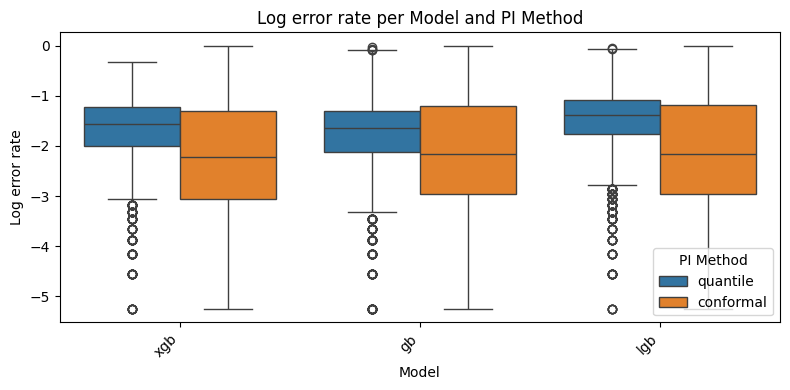

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Coverage plot
plt.figure(figsize=(8, 4))
sns.boxplot(x='model', y='log_error_rate', hue='pi_method', data=df)
plt.title('Log error rate per Model and PI Method')
plt.xlabel('Model')
plt.ylabel('Log error rate')
plt.xticks(rotation=45, ha='right')
plt.legend(title='PI Method')
plt.tight_layout()
plt.show()

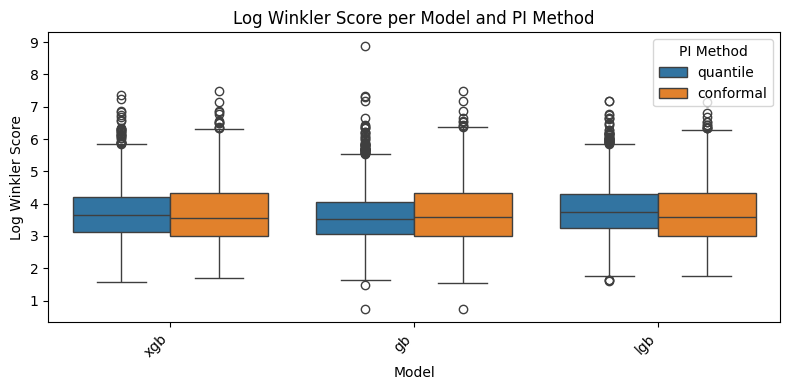

In [62]:
# Winkler plot
plt.figure(figsize=(8, 4))
sns.boxplot(x='model', y='log_winkler', hue='pi_method', data=df)
plt.title('Log Winkler Score per Model and PI Method')
plt.xlabel('Model')
plt.ylabel('Log Winkler Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='PI Method')
plt.tight_layout()
plt.show()

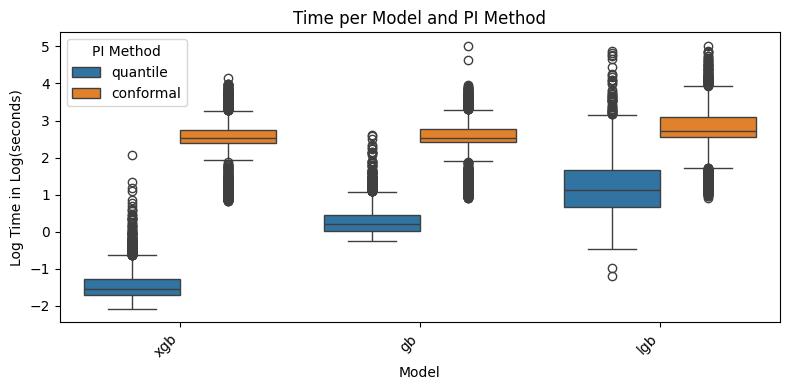

In [63]:
# Time plot
plt.figure(figsize=(8, 4))
sns.boxplot(x='model', y='log_time', hue='pi_method', data=df)
plt.title('Time per Model and PI Method')
plt.xlabel('Model')
plt.ylabel('Log Time in Log(seconds)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='PI Method')
plt.tight_layout()
plt.show()

Conformalizing requires splitting the data and fitting twice, so is logically slower. 

# 3 - 250 various time series (210 real-world, 40 synthetic)

250 time series, 240 real-world, 10 synthetic. See [https://github.com/Techtonique/datasets/blob/main/time_series/univariate/250datasets/250timeseries.txt](https://github.com/Techtonique/datasets/blob/main/time_series/univariate/250datasets/250timeseries.txt) for the list of time series, and [https://github.com/Techtonique/datasets/blob/main/time_series/univariate/250datasets/250datasets_characteristics.R](https://github.com/Techtonique/datasets/blob/main/time_series/univariate/250datasets/250datasets_characteristics.R) for their characteristics.

In [ ]:
!pip install rpy2

In [2]:
%load_ext rpy2.ipython

In [ ]:
%%R

utils::install.packages(c('forecast', 'fpp', 'fpp2', 'remotes'))
remotes::install_github("Techtonique/ahead")
remotes::install_github("thierrymoudiki/simulatetimeseries")
## ----"6-twofiftydatasets", echo=FALSE, cache=TRUE, message=FALSE, warning=FALSE-------------------------------------

utils::install.packages(c("astsa",
 "datasets",
 "expsmooth",
 "fma",
 "forecast",
 "fpp",
 "fpp2",
 "MASS",
 "remotes",
 "reshape2",
 "tswge"), repos="https://cran.r-project.org", quiet=TRUE)
remotes::install_github("thierrymoudiki/simulatetimeseries")
remotes::install_github("herbps10/AdaptiveConformal")
remotes::install_github("Techtonique/ahead")

install.packages("foreach", repos="https://cran.r-project.org")
install.packages("forecast", repos="https://cran.r-project.org")


suppressWarnings(library(datasets))
suppressWarnings(library(forecast))
suppressWarnings(library(fpp2))
suppressWarnings(library(ahead))
suppressWarnings(library(simulatetimeseries))


## ----"1-foursynthplot", echo=FALSE, cache=TRUE, message=FALSE, warning=FALSE, fig.cap="4 synthetic data sets (among 47)"----
suppressWarnings(library(datasets))
suppressWarnings(library(forecast))
suppressWarnings(library(fpp2))
suppressWarnings(library(ahead))
suppressWarnings(library(simulatetimeseries))

In [ ]:
%%R 

# /!\ Despite package name, these are mostly real-world time series (210), differenced once
# (see https://github.com/Techtonique/datasets/blob/main/time_series/univariate/250datasets/250timeseries.txt)
all_datasets <- simulatetimeseries::get_data_1() # easier is to download https://github.com/Techtonique/datasets/blob/main/time_series/univariate/250datasets/all_datasets.rds

row_names <- names(all_datasets)

visualizing a few examples among the 250 time series

[1] 250

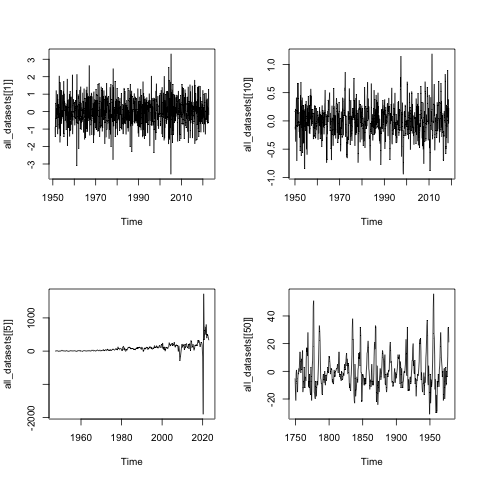

In [7]:
%%R

print(length(all_datasets))
par(mfrow=c(2, 2))
plot(all_datasets[[1]])
plot(all_datasets[[10]])
plot(all_datasets[[5]])
plot(all_datasets[[50]])

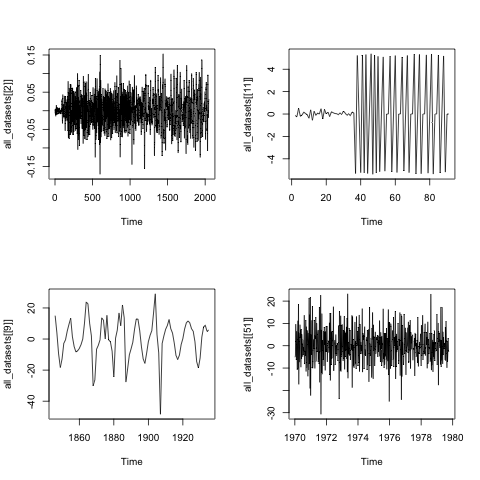

In [8]:
%%R

par(mfrow=c(2, 2))
plot(all_datasets[[2]])
plot(all_datasets[[11]])
plot(all_datasets[[9]])
plot(all_datasets[[51]])

In [9]:
%%R

# EXAMPLE ON A DATA SET CONTAINING 250 TIME SERIES ------------------------------------------------------------
col_names <- c("thetaf_0", "dynrmf_0",
               "thetaf_kde", "dynrmf_kde",
               "thetaf_boot", "dynrmf_boot",
               "thetaf_surr", "dynrmf_surr")

n_datasets <- length(all_datasets)
n_methods <- length(col_names)
results_winkler_score <- results_coverage_rate <- matrix(0, nrow=n_datasets, ncol=n_methods)

rownames(results_winkler_score) <- row_names
colnames(results_winkler_score) <- col_names
rownames(results_coverage_rate) <- row_names
colnames(results_coverage_rate) <- col_names

results_winkler_score <- as.data.frame(results_winkler_score)
results_coverage_rate <- as.data.frame(results_coverage_rate)

params <- vector("list", n_methods)
names(params) <- col_names

level <- 95
pct_train <- 0.9
pct_calibration <- 0.5

types_sim <- c("kde", "boot", "surr")

library("foreach")

pb <- txtProgressBar(min = 0,
                      max = n_datasets,
                      style = 3)
progress <- function(n)
  utils::setTxtProgressBar(pb, n)
opts <- list(progress = progress)

  |                                                                      |   0%

In [10]:
%%R

idx_dataset <- NULL
pb <- utils::txtProgressBar(min = 0, max = n_datasets, style = 3)

for(idx_dataset in 1:n_datasets) {

  selected_data <- all_datasets[[idx_dataset]]
  # no conformalization
  fit_obj <- try(ahead::fitforecast(selected_data, conformalize = 0, pct_train = pct_train,
                          pct_calibration=pct_calibration,
                          method = "dynrmf"), silent = TRUE)
  if (!inherits(fit_obj, "try-error"))
  {
  results_winkler_score[, "dynrmf_0"][idx_dataset] <- fit_obj$winkler_score
  results_coverage_rate[, "dynrmf_0"][idx_dataset] <- fit_obj$coverage
  } else {
    results_winkler_score[, "dynrmf_0"][idx_dataset] <- NA
    results_coverage_rate[, "dynrmf_0"][idx_dataset] <- NA
  }

  fit_obj <- try(ahead::fitforecast(selected_data, conformalize = 0, pct_train = pct_train,
                          pct_calibration=pct_calibration,
                          method = "thetaf"), silent = TRUE)
  if (!inherits(fit_obj, "try-error"))
  {
  results_winkler_score[, "thetaf_0"][idx_dataset] <- fit_obj$winkler_score
  results_coverage_rate[, "thetaf_0"][idx_dataset] <- fit_obj$coverage
  } else {
    results_winkler_score[, "thetaf_0"][idx_dataset] <- NA
    results_coverage_rate[, "thetaf_0"][idx_dataset] <- NA
  }

  # conformalization
  for (type_sim in types_sim){
    fit_obj <- try(ahead::fitforecast(selected_data, conformalize = 1,
                            pct_train = pct_train,
                            pct_calibration=pct_calibration,
                            method = "dynrmf", type_sim = type_sim), silent = TRUE)
    if (!inherits(fit_obj, "try-error"))
  {
    results_winkler_score[, paste0('dynrmf', '_', type_sim)][idx_dataset] <- fit_obj$winkler_score
    results_coverage_rate[, paste0('dynrmf', '_', type_sim)][idx_dataset] <- fit_obj$coverage #abs(fit_obj$coverage/level - 1)*100
    } else {
      results_winkler_score[, paste0('dynrmf', '_', type_sim)][idx_dataset] <- NA
      results_coverage_rate[, paste0('dynrmf', '_', type_sim)][idx_dataset] <- NA
    }

    fit_obj <- try(ahead::fitforecast(selected_data, conformalize = 1,
                            pct_train = pct_train,
                            pct_calibration=pct_calibration,
                            method = "thetaf", type_sim = type_sim), silent = TRUE)
    if (!inherits(fit_obj, "try-error"))
  {
    results_winkler_score[, paste0('thetaf', '_', type_sim)][idx_dataset] <- fit_obj$winkler_score
    results_coverage_rate[, paste0('thetaf', '_', type_sim)][idx_dataset] <- fit_obj$coverage #abs(fit_obj$coverage/level - 1)*100
    } else {
    results_winkler_score[, paste0('thetaf', '_', type_sim)][idx_dataset] <- NA
    results_coverage_rate[, paste0('thetaf', '_', type_sim)][idx_dataset] <- NA
  }

    }
    utils::setTxtProgressBar(pb, idx_dataset)
}

close(pb)
saveRDS(object = results_winkler_score, file = "results_winkler_score.rds")
saveRDS(object = results_coverage_rate, file = "results_coverage_rate.rds")

  |======================================================================| 100%


De plus : Il y a eu 50 avis ou plus (utilisez warnings() pour voir les 50 premiers)


In [29]:
%%R 

# Expected coverage rate: 95%
# methods ending with "_0" are not conformalized
# all the other methods are conformalized
coverage_ci <- t(apply(results_coverage_rate, 2, function(x) c(mean(x, na.rm = TRUE), 
quantile(x, c(0.025, 0.975), na.rm = TRUE))))
colnames(coverage_ci) <- c("mean", "lower", "upper")
coverage_ci <- as.data.frame(coverage_ci)
coverage_ci$method <- rownames(coverage_ci)
coverage_ci


                mean    lower upper      method
thetaf_0    88.83283 31.57895   100    thetaf_0
dynrmf_0    87.69836 34.27419   100    dynrmf_0
thetaf_kde  88.22848 28.38095   100  thetaf_kde
dynrmf_kde  93.77326 63.22967   100  dynrmf_kde
thetaf_boot 82.48538 15.77303   100 thetaf_boot
dynrmf_boot 89.86451 33.33333   100 dynrmf_boot
thetaf_surr 84.88912 26.66667   100 thetaf_surr
dynrmf_surr 91.56125 56.22222   100 dynrmf_surr


In [30]:
%%R

# Winkler score, the lower the better
# methods ending with "_0" are not conformalized
# all the other methods are conformalized
winkler_ci <- t(apply(results_winkler_score, 2, function(x) c(mean(x, na.rm = TRUE), 
quantile(x, c(0.025, 0.975), na.rm = TRUE))))
colnames(winkler_ci) <- c("mean", "lower", "upper")
winkler_ci <- as.data.frame(winkler_ci)
winkler_ci$method <- rownames(winkler_ci)
winkler_ci


                mean     lower     upper      method
thetaf_0    49775.61 0.3749945 150265.61    thetaf_0
dynrmf_0    21427.87 0.3624831  70254.36    dynrmf_0
thetaf_kde  45347.61 0.3803968 144066.16  thetaf_kde
dynrmf_kde  20929.91 0.3775642  62999.15  dynrmf_kde
thetaf_boot 48121.65 0.3480542 144554.24 thetaf_boot
dynrmf_boot 22728.10 0.3433424  61013.21 dynrmf_boot
thetaf_surr 48790.68 0.3499667 144421.17 thetaf_surr
dynrmf_surr 22467.88 0.3436461  61741.29 dynrmf_surr


# 4 - Synthetic data (25 time series)

In [ ]:
%%R 

# EXAMPLE ON A SYNTHETIC DATA SET ------------------------------------------------------------
## ----echo=FALSE, cache=FALSE, message=FALSE, warning=FALSE----------------------------------------------------------
winkler_score <- function(obj, actual, level = 95) {
  alpha <- 1 - level / 100
  lt <- obj$lower
  ut <- obj$upper
  n_points <- length(actual)
  stopifnot((n_points == length(lt)) && (n_points == length(ut)))
  diff_lt <- lt - actual
  diff_bounds <- ut - lt
  diff_ut <- actual - ut
  score <-
    diff_bounds + (2 / alpha) * (pmax(diff_lt, 0) + pmax(diff_ut, 0))
  return(mean(score))
}


## ----"7-aci-agci", echo=FALSE, cache=TRUE, message=FALSE, warning=FALSE---------------------------------------------
library("AdaptiveConformal")
library("ahead")
library("simulatetimeseries")
library("foreach")
library("forecast")

B <- 100
params_psi <- params_theta <- c(0.1, 0.8, 0.9, 0.95, 0.99)
levels <- c(80, 95)
fcast_methods <- c("thetaf", "dynrmf")
conformal_methods <- c("splitconformal", "AgACI", "SAOCP", "SF-OGD")

(params_grid <- expand.grid(params_psi, params_theta,
                            levels, fcast_methods,
                            conformal_methods))
colnames(params_grid) <- c("psi", "theta",
                           "level",
                           "fcast_method",
                           "conformal_method")
params_grid$fcast_method <- as.vector(params_grid$fcast_method)
params_grid$conformal_method <- as.vector(params_grid$conformal_method)

results <- matrix(0, ncol=B, nrow=nrow(params_grid))
colnames(results) <- paste0("B", seq_len(B))

params_grid <- params_grid2 <- cbind.data.frame(params_grid, results)

nb_iter <- nrow(params_grid)

pb <- txtProgressBar(min = 0,
                     max = nb_iter,
                     style = 3)

for (i in 1:nrow(params_grid))
{
  for (j in 6:ncol(params_grid))
  {
    seed_i_j <- 100*i+300*j

    y <- simulatetimeseries::simulate_time_series_4(n = 600,
                                                    params_grid$psi[i],
                                                    params_grid$theta[i],
                                                    seed=seed_i_j)
    splitted_ts <- simulatetimeseries::splitts(y = y, split_prob = 0.9)
    y_train <- splitted_ts$training
    y_test <- splitted_ts$testing

    if (as.character(params_grid$conformal_method[i]) == "splitconformal")
    {
      obj <- ahead::fitforecast(y,
                                conformalize = TRUE,
                                pct_train = 0.9,
                                pct_calibration = 0.5,
                                method = as.character(params_grid$fcast_method[i]),
                                type_calibration = "splitconformal",
                                level = params_grid$level[i],
                                type_sim = "kde",
                                graph = FALSE
      )
      params_grid[i, j] <- obj$coverage
      params_grid2[i, j] <- obj$winkler_score
    }

    if (as.character(params_grid$conformal_method[i]) %in% c("AgACI", "SAOCP", "SF-OGD"))
    {
      obj <- switch(as.character(params_grid$fcast_method[i]),
                      thetaf = forecast::thetaf(y_train, h=length(y_test)),
                      dynrmf = ahead::dynrmf(y_train, h=length(y_test)))
      preds <- obj$mean
      result <- AdaptiveConformal::aci(as.vector(y_test),
                                       as.vector(preds),
                                       method = as.character(params_grid$conformal_method[i]),
                                       alpha = params_grid$level[i]/100)
      result$lower <- result$intervals[, 1]
      result$upper <- result$intervals[, 2]
      params_grid[i, j] <- result$metrics$coverage*100
      params_grid2[i, j] <- winkler_score(result, actual=y_test, level = params_grid$level[i])
    }
  }
  utils::setTxtProgressBar(pb, i)
}

close(pb)

saveRDS(params_grid, "params_grid_coverages.rds")
saveRDS(params_grid2, "params_grid_winkler.rds")

## 4 - 1 Coverage rates for synthetic data

In [ ]:
%%R 

# CONFIDENCE INTERVALS FOR THE SYNTHETIC DATA SET
## ----"11-ag-agci-confint-coverage", echo=FALSE, cache=TRUE, warning=FALSE, message=FALSE----------------------------
utils::install.packages("dplyr", repos = "https://cran.r-project.org")
library("dplyr")
df <- reshape2::melt(params_grid,
                          id.vars=c("level",
                           "fcast_method",
                           "conformal_method"),
                          measure.vars=paste0("B", seq_len(B)))
df$variable <- NULL

In [ ]:
%%R 

utils::install.packages("patchwork")
library(patchwork)

`summarise()` has grouped output by 'fcast_method'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'fcast_method'. You can override using the
`.groups` argument.


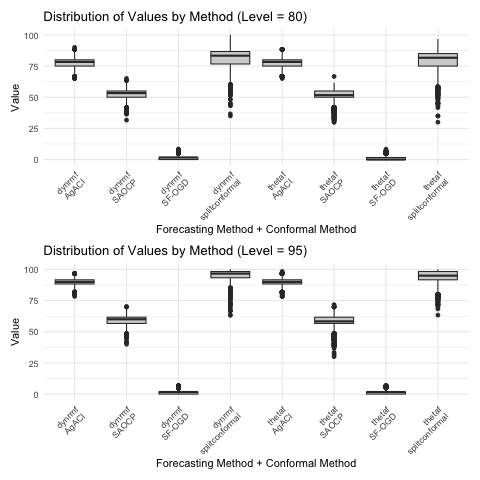

In [100]:
%%R

# Create interaction label for x-axis
df$method_combo <- paste(df$fcast_method, df$conformal_method, sep="\n")

# Summary tables for each level
table_80 <- df %>%
  filter(level == 80) %>%
  group_by(fcast_method, conformal_method) %>%
  summarise(
    mean = mean(value),
    sd = sd(value),
    median = median(value),
    q25 = quantile(value, 0.25),
    q75 = quantile(value, 0.75)
  ) %>%
  arrange(desc(mean))

table_95 <- df %>%
  filter(level == 95) %>%
  group_by(fcast_method, conformal_method) %>%
  summarise(
    mean = mean(value),
    sd = sd(value),
    median = median(value),
    q25 = quantile(value, 0.25),
    q75 = quantile(value, 0.75)
  ) %>%
  arrange(desc(mean))

# Plot for level 80
p1 <- ggplot(df[df$level == 80,], aes(x=method_combo, y=value)) +
  geom_boxplot(fill="lightgray") +
  labs(title="Distribution of Coverage Rates by Method (Level = 80)",
       x="Forecasting Method + Conformal Method",
       y="Value") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Plot for level 95
p2 <- ggplot(df[df$level == 95,], aes(x=method_combo, y=value)) +
  geom_boxplot(fill="lightgray") +
  labs(title="Distribution of Coverage Rates by Method (Level = 95)",
       x="Forecasting Method + Conformal Method",
       y="Value") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Display plots one after another using patchwork
library(patchwork)
print(p1 / p2)

In [105]:
%%R

# Print formatted tables
cat("Coverage Rate Summary Statistics for Level 80:\n")
print(kable(table_80, digits = 2))

Coverage Rate Summary Statistics for Level 80:


|fcast_method |conformal_method |  mean|   sd| median|   q25|   q75|
|:------------|:----------------|-----:|----:|------:|-----:|-----:|
|dynrmf       |splitconformal   | 81.40| 7.37|  83.33| 76.67| 86.67|
|thetaf       |splitconformal   | 79.85| 8.50|  81.67| 75.00| 85.00|
|dynrmf       |AgACI            | 77.61| 4.06|  78.33| 75.00| 80.00|
|thetaf       |AgACI            | 77.41| 4.08|  78.33| 75.00| 80.00|
|dynrmf       |SAOCP            | 52.77| 3.76|  53.33| 50.00| 55.00|
|thetaf       |SAOCP            | 51.81| 4.73|  51.67| 50.00| 55.00|
|dynrmf       |SF-OGD           |  1.20| 1.39|   1.67|  0.00|  1.67|
|thetaf       |SF-OGD           |  1.16| 1.38|   0.00|  0.00|  1.67|


In [106]:
%%R

cat("\nCoverage Rate Summary Statistics for Level 95:\n")
print(kable(table_95, digits = 2))


Coverage Rate Summary Statistics for Level 95:




|fcast_method |conformal_method |  mean|   sd| median|   q25|   q75|
|:------------|:----------------|-----:|----:|------:|-----:|-----:|
|dynrmf       |splitconformal   | 95.57| 4.12|  96.67| 93.33| 98.33|
|thetaf       |splitconformal   | 94.38| 4.96|  95.00| 91.67| 98.33|
|dynrmf       |AgACI            | 89.98| 3.02|  90.00| 88.33| 91.67|
|thetaf       |AgACI            | 89.74| 3.12|  90.00| 88.33| 91.67|
|dynrmf       |SAOCP            | 59.56| 3.85|  60.00| 56.67| 61.67|
|thetaf       |SAOCP            | 58.41| 4.91|  58.33| 56.67| 61.67|
|dynrmf       |SF-OGD           |  1.19| 1.39|   1.67|  0.00|  1.67|
|thetaf       |SF-OGD           |  1.17| 1.37|   1.67|  0.00|  1.67|


## 4 - 2 Winkler scores for synthetic data

The lower the better.

In [107]:
%%R 

## ----"12-ag-agci-confint-winkler", echo=FALSE, cache=TRUE, warning=FALSE, message=FALSE-----------------------------
df <- reshape2::melt(params_grid2,
                          id.vars=c("level",
                           "fcast_method",
                           "conformal_method"),
                          measure.vars=paste0("B", seq_len(B)))
df$variable <- NULL


`summarise()` has grouped output by 'fcast_method'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'fcast_method'. You can override using the
`.groups` argument.


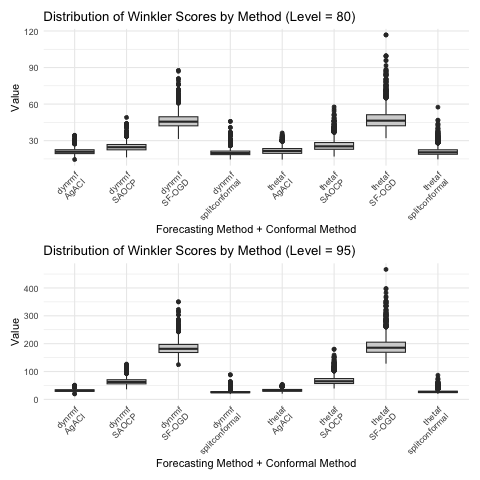

In [108]:
%%R

# Create interaction label for x-axis
df$method_combo <- paste(df$fcast_method, df$conformal_method, sep="\n")

# Summary tables for each level
table_80 <- df %>%
  filter(level == 80) %>%
  group_by(fcast_method, conformal_method) %>%
  summarise(
    mean = mean(value),
    sd = sd(value),
    median = median(value),
    q25 = quantile(value, 0.25),
    q75 = quantile(value, 0.75)
  ) %>%
  arrange(desc(mean))

table_95 <- df %>%
  filter(level == 95) %>%
  group_by(fcast_method, conformal_method) %>%
  summarise(
    mean = mean(value),
    sd = sd(value),
    median = median(value),
    q25 = quantile(value, 0.25),
    q75 = quantile(value, 0.75)
  ) %>%
  arrange(desc(mean))

# Plot for level 80
p1 <- ggplot(df[df$level == 80,], aes(x=method_combo, y=value)) +
  geom_boxplot(fill="lightgray") +
  labs(title="Distribution of Winkler Scores by Method (Level = 80)",
       x="Forecasting Method + Conformal Method",
       y="Value") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Plot for level 95
p2 <- ggplot(df[df$level == 95,], aes(x=method_combo, y=value)) +
  geom_boxplot(fill="lightgray") +
  labs(title="Distribution of Winkler Scores by Method (Level = 95)",
       x="Forecasting Method + Conformal Method",
       y="Value") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Display plots one after another using patchwork
library(patchwork)
print(p1 / p2)

In [109]:
%%R

# Print formatted tables
cat("Winkler Score Summary Statistics for Level 80:\n")
print(kable(table_80, digits = 2))

Winkler Score Summary Statistics for Level 80:


|fcast_method |conformal_method |  mean|   sd| median|   q25|   q75|
|:------------|:----------------|-----:|----:|------:|-----:|-----:|
|thetaf       |SF-OGD           | 47.91| 8.74|  46.39| 42.21| 51.26|
|dynrmf       |SF-OGD           | 46.16| 6.03|  45.57| 42.16| 49.59|
|thetaf       |SAOCP            | 26.23| 5.01|  25.33| 22.90| 28.45|
|dynrmf       |SAOCP            | 24.95| 3.59|  24.61| 22.47| 26.83|
|thetaf       |AgACI            | 21.85| 3.10|  21.53| 19.58| 23.52|
|thetaf       |splitconformal   | 21.16| 3.79|  20.41| 18.82| 22.50|
|dynrmf       |AgACI            | 21.07| 2.49|  20.87| 19.37| 22.55|
|dynrmf       |splitconformal   | 20.28| 2.85|  19.78| 18.53| 21.44|


In [110]:
%%R

# Print formatted tables
# Winkler score, the lower the better
cat("Winkler Score Summary Statistics for Level 95:\n")
print(kable(table_95, digits = 2))


Winkler Score Summary Statistics for Level 95:


|fcast_method |conformal_method |   mean|    sd| median|    q25|    q75|
|:------------|:----------------|------:|-----:|------:|------:|------:|
|thetaf       |SF-OGD           | 191.33| 33.69| 185.45| 169.11| 205.35|
|dynrmf       |SF-OGD           | 183.80| 23.78| 181.53| 168.26| 197.23|
|thetaf       |SAOCP            |  67.82| 16.35|  65.02|  56.87|  74.78|
|dynrmf       |SAOCP            |  63.90| 11.80|  62.66|  55.78|  70.58|
|thetaf       |AgACI            |  32.80|  4.95|  32.20|  29.26|  35.67|
|dynrmf       |AgACI            |  31.82|  4.15|  31.53|  28.83|  34.36|
|thetaf       |splitconformal   |  28.01|  6.01|  26.39|  24.51|  29.46|
|dynrmf       |splitconformal   |  26.56|  4.68|  25.63|  24.05|  27.89|


# 5 - Session info

## 5 - 1 Python

In [70]:
import platform

# Get basic machine information
python_version = platform.python_version()

print("Python Version:", python_version)

Python Version: 3.11.10


In [71]:
import psutil

# CPU Information
cpu_count = psutil.cpu_count(logical=True)
cpu_freq = psutil.cpu_freq()
cpu_usage = psutil.cpu_percent(interval=1)

# Memory Information
virtual_memory = psutil.virtual_memory()
swap_memory = psutil.swap_memory()

# Disk Information
disk_usage = psutil.disk_usage('/')

print(f"CPU Count: {cpu_count}")
print(f"CPU Frequency: {cpu_freq.current} MHz")

CPU Count: 8
CPU Frequency: 1100 MHz


In [72]:
!pip freeze

Python(54508) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


appnope==0.1.4
asttokens==2.4.1
certifi==2024.12.14
cffi==1.17.1
charset-normalizer==3.4.1
click==8.1.7
comm==0.2.1
contourpy==1.3.1
cycler==0.12.1
debugpy==1.8.1
decorator==5.1.1
executing==2.0.1
fonttools==4.55.3
idna==3.10
ipykernel==6.29.3
ipython==8.22.2
jedi==0.19.1
Jinja2==3.1.5
joblib==1.4.2
jupyter_client==8.6.0
jupyter_core==5.7.1
kiwisolver==1.4.8
lightgbm==4.5.0
MarkupSafe==3.0.2
matplotlib==3.10.0
matplotlib-inline==0.1.6
nest-asyncio==1.6.0
nnetsauce==0.29.5
numpy==2.2.1
packaging==23.2
pandas==2.2.3
parso==0.8.3
patsy==1.0.1
pexpect==4.9.0
pillow==11.1.0
platformdirs==4.2.0
prompt-toolkit==3.0.43
psutil==5.9.8
ptyprocess==0.7.0
pure-eval==0.2.2
pycparser==2.22
Pygments==2.17.2
pyparsing==3.2.1
python-dateutil==2.9.0.post0
pytz==2024.2
pyzmq==25.1.2
requests==2.32.3
rpy2==3.5.17
rtopy==0.1.1
scikit-learn==1.6.0
scipy==1.15.0
seaborn==0.13.2
six==1.16.0
stack-data==0.6.3
statsmodels==0.14.4
threadpoolctl==3.5.0
tornado==6.4
tqdm==4.67.1
traitlets==5.14.1
tzdata==2024.2
tzl

## 5 - 2 R

In [74]:
%R sessionInfo()

<rpy2.robjects.vectors.ListVector object at 0x11f778c50> [19]
R classes: ('sessionInfo',)
[ListSexpV..., StrSexpVe..., StrSexpVe..., StrSexpVe..., ..., StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe...]
<rpy2.robjects.vectors.ListVector object at 0x11f778c50> [19]
R classes: ('sessionInfo',)
[ListSexpV..., StrSexpVe..., StrSexpVe..., StrSexpVe..., ..., StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe...]
  platform: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x11f809ad0> [16]
R classes: ('character',)
['x86_64-apple-darwin20 (64-bit)']
  locale: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x11f5a12d0> [16]
R classes: ('character',)
['C/UTF-8/C/C/C/C']
  tzone: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x11f875110> [16]
R classes: ('character',)
['Europe/Paris']
...
  running: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x10df1bf50> [16]
R classes: ('character',)
['default']
  RNGkind: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x10df1bf10> [16]
R classes: ('character',)
['/System/Library/Frameworks/Accelerate.framework/...]
  basePkgs: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x11f718c10> [16]
R classes: ('character',)
['/Library/Frameworks/R.framework/Versions/4.3-x86...]
  otherPkgs: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x10df1b450> [16]
R classes: ('character',)
['3.11.0']